In [1]:
%load_ext autoreload
%autoreload 2

#### Sample Template for Housing data using code templates Regression

##### Imports

In [3]:
%%time
import yaml
import sys
import os

# adding the path to the scripts to sys
sys.path.append(os.path.join(os.getcwd(),"../.." ))
import utils
from data_processing import DataPrep, MiceImputer,Encoder,DataProcessor
from data_processing import tiger_dataframe as td
from eda import Analyser,DataExplorer
import model_gen as mg
import model_eval as me
from feature_selection import FeatureSelector

Wall time: 0 ns


##### Config Read

In [4]:
cfg = utils.load_yml("config.yml")

In [5]:
cfg

{'data': {'input': {'path': './data/housing.csv',
   'target_column': 'median_house_value'},
  'outlier': {'handle': False,
   'remove': None,
   'impute': 'mean',
   'inf_is_outlier': False},
  'imputation': {'drop': False, 'numerical': 'knn', 'categorical': None},
  'encode_non_numeric': True,
  'train_test_split': {'shuffle': True,
   'train': 0.7,
   'test': 0.2,
   'validation': 0.1,
   'random_state': 11}},
 'fs': 'recursion',
 'feature_selection': {'regularization': {'estimator': 'sklearn.linear_model.Ridge',
   'estimator_params': {'alpha': 0.5}},
  'recursion': {'estimator': 'sklearn.linear_model.Ridge',
   'estimator_params': {'alpha': 0.5},
   'fs_params': {'forward': False, 'verbose': False, 'k_features': 'best'}}},
 'models': {'ridge': {'estimator': 'sklearn.linear_model.Ridge',
   'params': {'alpha': [5, 0.5]}},
  'lasso': {'estimator': 'sklearn.linear_model.Ridge',
   'params': {'alpha': [5, 0.5]}},
  'rf': {'estimator': 'sklearn.ensemble.RandomForestRegressor',
   'para

#### Data Read (Into a Tiger Dataframe(Wrapper around the generic Pandas DF))

In [6]:
df = td.read_csv(path=cfg['data']['input']['path'])

In [7]:
df.head()

In [8]:
df.tail()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [10]:
df.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

#### Data Health Report Generation

In [11]:
an = Analyser(data=df)
an.health_analysis(save_as='.html')

Started running health_analysis
Started running data_health
Started running duplicate_columns
Finished running duplicate_columns
Time taken to run duplicate_columns is 0 seconds
Finished running data_health
Time taken to run data_health is 0 seconds
Started running missing_plot
Finished running missing_plot
Time taken to run missing_plot is 0 seconds
Started running missing_value_summary
Finished running missing_value_summary
Time taken to run missing_value_summary is 0 seconds
Finished running health_analysis
Time taken to run health_analysis is 1 seconds


{'health_plot': :Layout
    .Bars.I   :Bars   [index,Variable]   (value)
    .Bars.II  :Bars   [index,Variable]   (value)
    .Bars.III :Bars   [index,Variable]   (value)
    .Bars.IV  :Bars   [index,Variable]   (value),
 'missing_plot': :Bars   [index]   (0),
 'missing_value_summary':    index   Variable Name  No of Missing  Per of Missing
 0      4  total_bedrooms            207        1.002907,
 'duplicate_columns': 'No duplicate variables',
 'outliers_in_features':                     < (mean-3*std)  > (mean+3*std)  < (1stQ - 1.5 * IQR)  \
 feature                                                                    
 households                       0             363                     0   
 median_house_value               0               0                     0   
 median_income                    0             345                     0   
 population                       0             342                     0   
 total_bedrooms                   0             368              

A health report should have been generated.
Looking at that report we can observe that
 - ocean_proximity is the only categorical var with 5 cats
 - Data is relatively clean
 - No Missing data
 - Outliers are observed in the data. Both wrt +-3sdv or +-1.5 IQR from relevant quantiles(We have to look more into this)

Hence not a lot of cleaning is required in the data

#### Distribution of these outliers wrt Ocean Proximity

#### Feature Analysis and Interactions

In [12]:
an = Analyser(data=df)
an.feature_analysis(save_as=".html")

Started running feature_analysis
Started running numeric_summary
Started running variable_summary
Finished running variable_summary
Time taken to run variable_summary is 0 seconds
Finished running numeric_summary
Time taken to run numeric_summary is 0 seconds
Started running non_numeric_summary
Started running variable_summary
Finished running variable_summary
Time taken to run variable_summary is 0 seconds
Finished running non_numeric_summary
Time taken to run non_numeric_summary is 0 seconds
Started running density_plots
Finished running density_plots
Time taken to run density_plots is 0 seconds
Started running percentile_plots
Finished running percentile_plots
Time taken to run percentile_plots is 0 seconds
Started running non_numeric_frequency_plot
Finished running non_numeric_frequency_plot
Time taken to run non_numeric_frequency_plot is 0 seconds
Started running feature_normality
Finished running feature_normality
Time taken to run feature_normality is 0 seconds


p-value may not be accurate for N > 5000.


Finished running feature_analysis
Time taken to run feature_analysis is 4 seconds


{'summary_stats': {'numeric_variables': [<tigerml.dataframe.dataframe.DataFrame at 0x1fa0c4a9f70>],
  'non_numeric_variables': [<tigerml.dataframe.dataframe.DataFrame at 0x1fa19a9be20>]},
 'distributions': {'numeric_variables': {'households': [:Layout
       .Distribution.I :Distribution   [households]   (Density)
       .Table.I        :Table   [count,mean,std,min,25%,50%,75%,max],
    :Layout
       .Bars.Households :Bars   [index]   (households)
       .Table.I         :Table   [min,0.2%,0.4%,0.6%,0.8%,1%]
       .Table.II        :Table   [99%,99.2%,99.4%,99.6%,99.8%]],
   'housing_median_age': [:Layout
       .Distribution.I :Distribution   [housing_median_age]   (Density)
       .Table.I        :Table   [count,mean,std,min,25%,50%,75%,max],
    :Layout
       .Bars.Housing_median_age :Bars   [index]   (housing_median_age)
       .Table.I                 :Table   [min,0.2%,0.4%,0.6%,0.8%,1%]
       .Table.II                :Table   [99%,99.2%,99.4%,99.6%,99.8%]],
   'latitude': [:L

#### Feature Interactions

In [13]:
an = Analyser(data=df)
an.feature_interactions(save_as=".html")

Started running feature_interactions
Started running preprocess_data
Cleaning data
Imputing missing values with median for numeric data and mode for categorical data.
There are 207 missing values in the variable - total_bedrooms
All missing values are imputed with median
No Infinity values
Encoding categorical variables with default settings which will not be ideal. Processing these variables manually is highly recommended.
Finished running preprocess_data
Time taken to run preprocess_data is 0 seconds
Started running correlation_table
Finished running correlation_table
Time taken to run correlation_table is 0 seconds
Started running correlation_heatmap
Finished running correlation_heatmap
Time taken to run correlation_heatmap is 0 seconds
Finished running feature_interactions
Time taken to run feature_interactions is 0 seconds


{'correlation_table': [                                   Variable 1  \
  0                                  households   
  1                              total_bedrooms   
  2                                    latitude   
  3                                  households   
  4                                  households   
  ..                                        ...   
  86                              median_income   
  87      onehot_encoded_ocean_proximity_ISLAND   
  88   onehot_encoded_ocean_proximity_<1H OCEAN   
  89                                 households   
  90  onehot_encoded_ocean_proximity_NEAR OCEAN   
  
                                     Variable 2  Coer Coef  Abs Coer Coef  
  0                              total_bedrooms   0.974366       0.974366  
  1                                 total_rooms   0.927058       0.927058  
  2                                   longitude  -0.924664       0.924664  
  3                                 total_rooms   0.918484  

#### Key Features

Started running preprocess_data
Cleaning data
No missing values
No Infinity values
Encoding categorical variables with default settings which will not be ideal. Processing these variables manually is highly recommended.
ocean_proximity has levels with less than 413 (2.0%) values. Target encoding in such cases is not recommended.
Finished running preprocess_data
Time taken to run preprocess_data is 0 seconds
Started running get_feature_scores
Finished running get_feature_scores
Time taken to run get_feature_scores is 0 seconds
Started running feature_importances


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Finished running feature_importances
Time taken to run feature_importances is 0 seconds
Started running get_pca_analysis


{'median_house_value': {'feature_scores': {'feature_correlation': :Bars   [index]   (Pearson_correlation_with_Target)},
  'feature_importances': {'from_model': :Bars   [index]   (importance)},
  'pca_analysis': "Cannot compute get_pca_analysis. Error - 'DataFrame' object has no attribute 'fit_transform'"}}

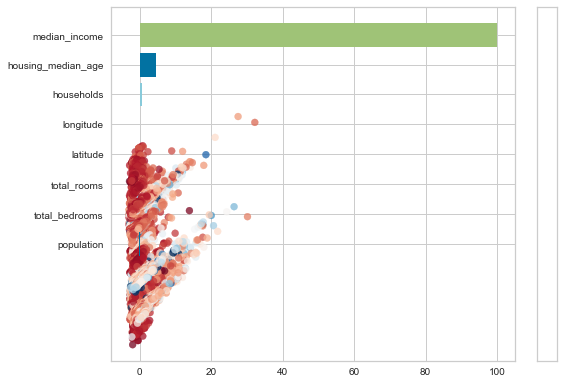

In [14]:
an = Analyser(data=df)
an.key_drivers(save_as=".html", y=cfg['data']['input']['target_column'])

#### Visualiser for Data (Furthermore, any other EDA or this can be got from the visualiser and summarised in story boarding)

In [15]:
df = df.categorize()
de = DataExplorer(df)
de.open(port=1006)

Launching server at http://localhost:1006


A visualiser shold have opened up in the above url

#### Data Processing for Modelling

###### Encoding Categorical X Features

In [16]:
en = Encoder(df, y=cfg['data']['input']['target_column'])

# default encoding is also available which does target encoding by default when y is provided
# else does one hot encoding.

# we can add custom rules for encoding if required.
# this will overwrite the default encoding and will only consider the below rules
en = en.add_encode_rule(cols=['ocean_proximity'], method='onehot')

# transforming the data into encoding
df_encoded = en.transform()

###### Data Prep

In [17]:
dp = DataProcessor(data=df_encoded, y=cfg['data']['input']['target_column'])
dp.get_numeric_columns(), dp.get_cat_columns(), dp.get_dt_columns(), dp.get_x_cols()

(['households',
  'housing_median_age',
  'latitude',
  'longitude',
  'median_house_value',
  'median_income',
  'onehot_encoded_ocean_proximity_<1H OCEAN',
  'onehot_encoded_ocean_proximity_INLAND',
  'onehot_encoded_ocean_proximity_ISLAND',
  'onehot_encoded_ocean_proximity_NEAR BAY',
  'onehot_encoded_ocean_proximity_NEAR OCEAN',
  'population',
  'total_bedrooms',
  'total_rooms'],
 ['ocean_proximity'],
 [],
 ['longitude',
  'latitude',
  'housing_median_age',
  'total_rooms',
  'total_bedrooms',
  'population',
  'households',
  'median_income',
  'ocean_proximity',
  'onehot_encoded_ocean_proximity_<1H OCEAN',
  'onehot_encoded_ocean_proximity_INLAND',
  'onehot_encoded_ocean_proximity_ISLAND',
  'onehot_encoded_ocean_proximity_NEAR BAY',
  'onehot_encoded_ocean_proximity_NEAR OCEAN'])

### Data Preparation like outlier treatment, If NA values are to be dropped based on config

In [18]:
data_prep=DataPrep(cfg)
data_prep.fit(df_encoded)
x_train, x_test, y_train, y_test = data_prep.transform(df_encoded)

In [19]:
x_train

households  housing_median_age  latitude  longitude  median_income  \
9436        509.0                14.0     37.51    -119.99         1.3980   
2802        334.0                45.0     35.42    -119.03         2.5703   
18511       325.0                43.0     36.98    -122.00         3.5562   
11241       339.0                34.0     33.81    -117.96         4.4663   
6409        329.0                37.0     34.12    -118.02         6.1536   
...           ...                 ...       ...        ...            ...   
17677       841.0                16.0     37.33    -121.85         2.8024   
4023        393.0                46.0     34.18    -118.52         3.6534   
7259        418.0                36.0     34.01    -118.17         2.7799   
3775        130.0                14.0     34.16    -118.41         4.1875   
10137       227.0                33.0     33.91    -117.89         3.7321   

       onehot_encoded_ocean_proximity_<1H OCEAN  \
9436                                          0   
2802                                          0   
18511                                         0   
11241                                         1   
6409                                          0   
...                                         ...   
17677                                         1   
4023                                          1   
7259                                          1   
3775                                          1   
10137                                         1   

       onehot_encoded_ocean_proximity_INLAND  \
9436                                       1   
2802                                       1   
18511                                      0   
11241                                      0   
6409                                       1   
...                                      ...   
17677                                      0   
4023                                       0   
7259                                       0   
3775                                       0   
10137                                      0   

       onehot_encoded_ocean_proximity_ISLAND  \
9436                                       0   
2802                                       0   
18511                                      0   
11241                                      0   
6409                                       0   
...                                      ...   
17677                                      0   
4023                                       0   
7259                                       0   
3775                                       0   
10137                                      0   

       onehot_encoded_ocean_proximity_NEAR BAY  \
9436                                         0   
2802                                         0   
18511                                        0   
11241                                        0   
6409                                         0   
...                                        ...   
17677                                        0   
4023                                         0   
7259                                         0   
3775                                         0   
10137                                        0   

       onehot_encoded_ocean_proximity_NEAR OCEAN  population  total_bedrooms  \
9436                                           0      1011.0           617.0   
2802                                           0       754.0           352.0   
18511                                          1       792.0           324.0   
11241                                          0      1021.0           356.0   
6409                                           0       989.0           360.0   
...                                          ...         ...             ...   
17677                                          0      4241.0           874.0   
4023                                           0      1047.0           438

### Imputations

In [20]:
imp_=MiceImputer(num_impute_method=cfg['data']['imputation']['numerical'],cat_impute_method=cfg['data']['imputation']['categorical'])
imp_.fit(x_train,y_train)
x_train_tranformed=imp_.transform(x_train)
x_test_tranformed=imp_.transform(x_test)

In [21]:
x_train_tranformed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14447 entries, 9436 to 10137
Data columns (total 13 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   households                                 14447 non-null  float64
 1   housing_median_age                         14447 non-null  float64
 2   latitude                                   14447 non-null  float64
 3   longitude                                  14447 non-null  float64
 4   median_income                              14447 non-null  float64
 5   onehot_encoded_ocean_proximity_<1H OCEAN   14447 non-null  uint8  
 6   onehot_encoded_ocean_proximity_INLAND      14447 non-null  uint8  
 7   onehot_encoded_ocean_proximity_ISLAND      14447 non-null  uint8  
 8   onehot_encoded_ocean_proximity_NEAR BAY    14447 non-null  uint8  
 9   onehot_encoded_ocean_proximity_NEAR OCEAN  14447 non-null  uint8  
 10  population         

In [22]:
cfg['data']['imputation']['numerical']

'knn'

### feature selection and transforming

In [23]:
sel_=FeatureSelector(cfg)
sel_.fit(x_train_tranformed,y_train)
x_train_selected=sel_.transform(x_train_tranformed)
x_test_selected=sel_.transform(x_test_tranformed)

selected features: ('households', 'housing_median_age', 'latitude', 'longitude', 'median_income', 'onehot_encoded_ocean_proximity_<1H OCEAN', 'onehot_encoded_ocean_proximity_INLAND', 'onehot_encoded_ocean_proximity_ISLAND', 'onehot_encoded_ocean_proximity_NEAR BAY', 'population', 'total_bedrooms', 'total_rooms')


#### Generation of Search List for Models

In [24]:
models = mg.list_models_from_config(cfg)

#### Evaluating or Comparing Models

In [25]:
rpt = me.RegressionComparison(models)

In [26]:
rpt.fit(x_train_selected, y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [27]:
rpt.score(x_test_selected, y_test)

Passing 6193 background samples may lead to slow runtimes. Consider using shap.sample(data, 100) to create a smaller background data set.
Passing 6193 background samples may lead to slow runtimes. Consider using shap.sample(data, 100) to create a smaller background data set.
 96%|=================== | 96/100 [00:15<00:00]       

`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pa

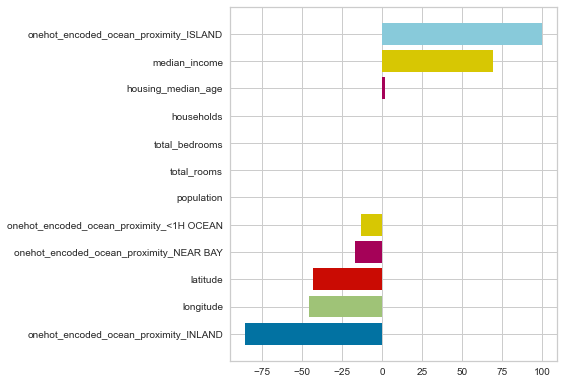

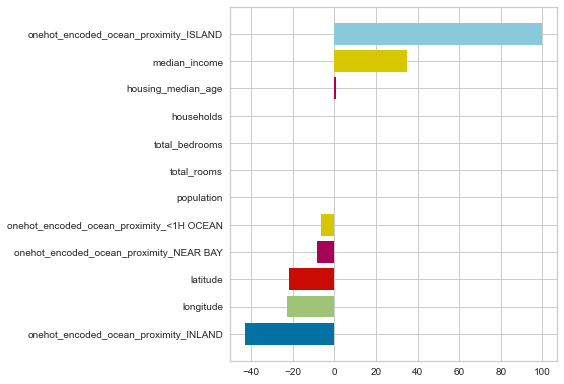

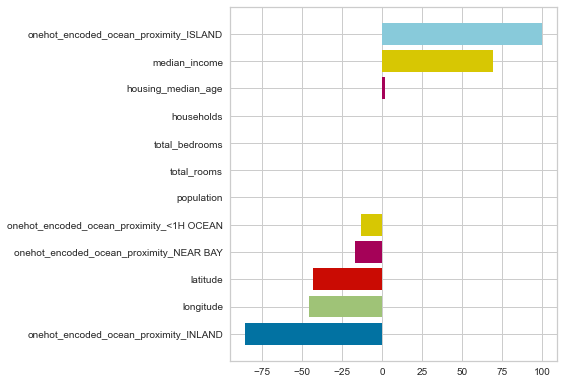

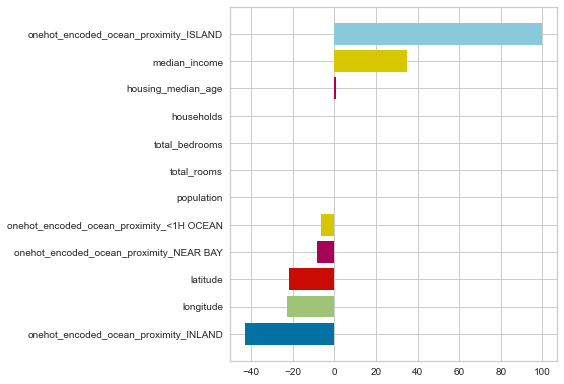

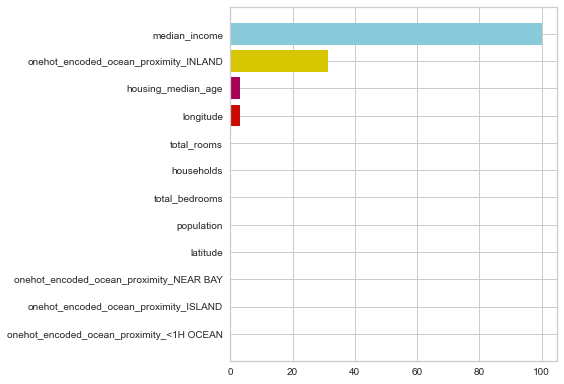

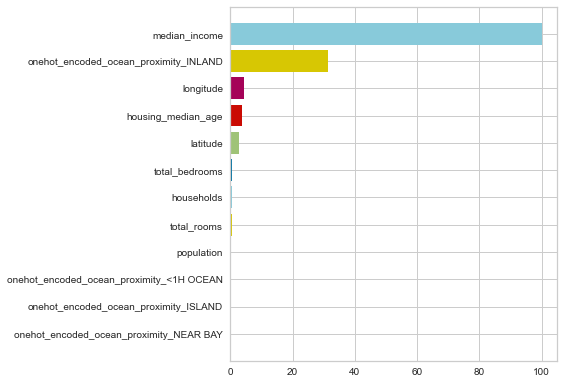

In [28]:
rpt.get_report()

In [32]:
# Way to Obtain the predictions 

In [33]:
# And Opening a Visualiser with the X_test, Y, Y_hat SO as to play around with the predictions